### Creation of Context

In [1]:
import pyspark
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [2]:
import pyspark.sql.functions as sf

### Preparation of Data

In [3]:
dataPath = "data.csv"
df = sqlc.read.format("csv")\
  .option("header","true")\
  .option("inferSchema", "true")\
  .load(dataPath)

In [4]:
df.printSchema() #Letting me know what variables are there

root
 |-- _c0: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- target: integer (nullable = true)
 |-- song_title: string (nullable = true)
 |-- artist: string (nullable = true)



In [5]:
parquetPath = '/home/ec2-user/SageMaker/Open-Data-Lab/education/as7cs' #Converting to Parquet. Error is popping up because I tried to do it twice after it was already created
df.write.parquet(parquetPath)

AnalysisException: 'path file:/home/ec2-user/SageMaker/Open-Data-Lab/education/as7cs already exists.;'

In [6]:
data = sqlc.read.parquet(parquetPath) #Reading Parquet
display(data)

DataFrame[_c0: int, acousticness: double, danceability: double, duration_ms: int, energy: double, instrumentalness: double, key: int, liveness: double, loudness: double, mode: int, speechiness: double, tempo: double, time_signature: double, valence: double, target: int, song_title: string, artist: string]

In [7]:
#Importing the last of my libraries
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

### MLlib based analysis

In [8]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- target: integer (nullable = true)
 |-- song_title: string (nullable = true)
 |-- artist: string (nullable = true)



In [9]:
df.take(5)

[Row(_c0=0, acousticness=0.0102, danceability=0.833, duration_ms=204600, energy=0.434, instrumentalness=0.0219, key=2, liveness=0.165, loudness=-8.795, mode=1, speechiness=0.431, tempo=150.062, time_signature=4.0, valence=0.286, target=1, song_title='Mask Off', artist='Future'),
 Row(_c0=1, acousticness=0.199, danceability=0.743, duration_ms=326933, energy=0.359, instrumentalness=0.00611, key=1, liveness=0.137, loudness=-10.401, mode=1, speechiness=0.0794, tempo=160.083, time_signature=4.0, valence=0.588, target=1, song_title='Redbone', artist='Childish Gambino'),
 Row(_c0=2, acousticness=0.0344, danceability=0.838, duration_ms=185707, energy=0.412, instrumentalness=0.000234, key=2, liveness=0.159, loudness=-7.148, mode=1, speechiness=0.289, tempo=75.044, time_signature=4.0, valence=0.173, target=1, song_title='Xanny Family', artist='Future'),
 Row(_c0=3, acousticness=0.604, danceability=0.494, duration_ms=199413, energy=0.338, instrumentalness=0.51, key=5, liveness=0.0922, loudness=-1

In [10]:
print("Pearson's r(danceability,duration_ms) = {}".format(df.corr("danceability", "duration_ms")))
print("Pearson's r(danceability,speechiness) = {}".format(df.corr("danceability", "speechiness")))
print("Pearson's r(speechiness,energy) = {}".format(df.corr("speechiness", "energy")))

Pearson's r(danceability,duration_ms) = 0.004695083530137932
Pearson's r(danceability,speechiness) = 0.14266052295556916
Pearson's r(speechiness,energy) = 0.09310231843447833


In [11]:
#There is no need to create any variables. Let's begin to select features for analysis

In [12]:
final = df.select("speechiness", "energy")

In [13]:
# create train/test sets
seed = 7
(testDF, trainingDF) = final.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 1605, test set N = 412


In [14]:
from pyspark.ml.linalg import Vectors, VectorUDT

In [15]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("speechiness", "oneElementVec(energy) as energy")
testDF = testDF.selectExpr("speechiness", "oneElementVec(energy) as energy")

print(testDF.orderBy(testDF.speechiness.desc()).limit(5))

DataFrame[speechiness: double, energy: vector]


In [16]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("speechiness", "label").withColumnRenamed("energy", "features")
testDF = testDF.withColumnRenamed("speechiness", "label").withColumnRenamed("energy", "features")

In [17]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [18]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

In [19]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=0.622, features=DenseVector([0.716]), prediction=0.09321535682780889), Row(label=0.542, features=DenseVector([0.746]), prediction=0.09438916344411563), Row(label=0.488, features=DenseVector([0.412]), prediction=0.08132078311590063), Row(label=0.484, features=DenseVector([0.851]), prediction=0.0984974866011892), Row(label=0.447, features=DenseVector([0.748]), prediction=0.09446741721853608)]


### Model Evaluation

In [20]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [21]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [22]:
eval.setMetricName("mse").evaluate(predictionsAndLabelsDF)

0.008986521328338949

In [23]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

0.09479726435050195

In [24]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.005868145141320724

### Data Visualization

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [26]:
type(final)

pyspark.sql.dataframe.DataFrame

In [27]:
final = final.toPandas()
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

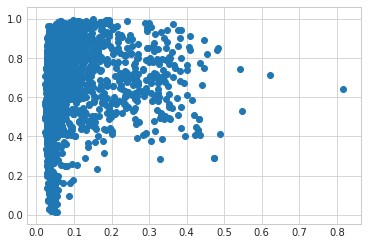

In [29]:
plt.scatter(final['speechiness'],final['energy'])

In [31]:
df2 = df.toPandas()

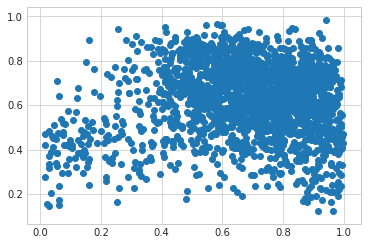

In [32]:
plt.scatter(df2['energy'], df2['danceability'])